# ENRON DATASET

In [1]:
# import dependencies
import email
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#load the data
emails = pd.read_csv("enron/emails.csv", nrows=50000)

In [3]:
#how does the data look?
print(emails.shape)
emails.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
#What format are the messages?
print(emails['message'][46])

Message-ID: <9007402.1075855688248.JavaMail.evans@thyme>
Date: Tue, 12 Sep 2000 06:42:00 -0700 (PDT)
From: phillip.allen@enron.com
To: bs_stone@yahoo.com
Subject: Re: Sept 1 Payment
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Brenda Stone <bs_stone@yahoo.com> @ ENRON
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Dec2000\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

Brenda,

 I checked my records and I mailed check #1178 for the normal amount on 
August 28th.  I mailed it to 4303 Pate Rd. #29, College Station, TX 77845.  I 
will go ahead and mail you another check.  If the first one shows up you can 
treat the 2nd as payment for October.

 I know your concerns about the site plan.  I will not proceed without 
getting the details and getting your approval.

 I will find that amortization schedule and send it soon.

Phillip


In [5]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)
def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [6]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails['message']))
emails.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails[key] = [doc[key] for doc in messages]
# Parse content from emails
emails['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails['From'] = emails['From'].map(split_email_addresses)
emails['To'] = emails['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails['user'] = emails['file'].map(lambda x:x.split('/')[0])
del messages

emails.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


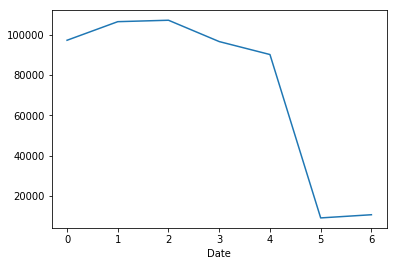

In [7]:
ax = emails.groupby(pd.to_datetime(emails['Date']).dt.dayofweek)['content'].count().plot()

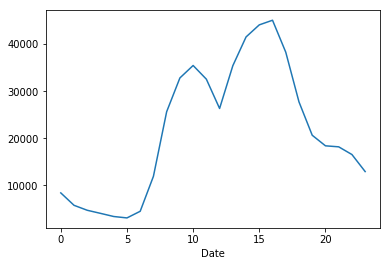

In [8]:
ax = emails.groupby(pd.to_datetime(emails['Date']).dt.hour)['content'].count().plot()

In [ ]:
import wordcloud
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
contents = ' '.join(emails.sample(50000)['content']).lower()
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=1000, 
                         height=1000, 
                         max_words=500,
                         stopwords=ENGLISH_STOP_WORDS).generate(contents)
ax.imshow(wc)
ax.axis("off")